# Solving the permuted sequential MNIST (psMNIST) task

The psMNIST (Permuted Sequential MNIST) task is a image classification task introduced
in 2015 by Le, Jaitly, and Hinton ([see paper](https://arxiv.org/pdf/1504.00941.pdf)).
It is based on the Sequential MNIST task, which itself is a derivative of the MNIST
task. Like the MNIST task, the goal of the psMNIST task is to have a neural network
process a 28 x 28 pixel image (of a handwritten digit) into one of ten digits (0 to 9).

However, while the MNIST task presents the entire image to the network all at once, the
Sequential MNIST and psMNIST tasks turn the image into a stream of 784 (28x28)
individual pixels, presented to the network one at a time. The goal of the network is
then to classify the pixel sequence as the appropriate digit after the last pixel has
been shown. The psMNIST task adds more complexity to the input by applying a fixed
permutation to all of the pixel sequences. This is done to ensure that the information
contained in the image is distributed evenly throughout the sequence, so that in order
to perform the task successfully the network needs to process information across the
whole length of the input sequence.

The following notebook uses a single KerasLMU layer inside a simple TensorFlow model to
showcase the accuracy and efficiency of performing the psMNIST task using these novel
memory cells. Using the LMU for this task currently produces state-of-the-art results
([see
paper](https://papers.nips.cc/paper/9689-legendre-memory-units-continuous-time-representation-in-recurrent-neural-networks.pdf)).

In [1]:
%matplotlib inline

import keras
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display
import tensorflow as tf

import keras_lmu

2025-06-03 21:40:25.555195: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-03 21:40:25.558018: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-03 21:40:25.566368: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748986825.580307    3778 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748986825.584478    3778 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748986825.595657    3778 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

## Loading and formatting the dataset

First we set a seed to ensure that the results in this example are reproducible. A
random number generator (`rng`) is also created, and this will later be used to
generate the fixed permutation to be applied to the image data.

In [2]:
seed = 0
tf.random.set_seed(seed)
np.random.seed(seed)
rng = np.random.RandomState(seed)

We now obtain the standard MNIST dataset of handwritten digits from `keras.datasets`.

In [3]:
(train_images, train_labels), (
    test_images,
    test_labels,
) = keras.datasets.mnist.load_data()

Since the pixel values of each image in the dataset have a range of 0 to 255, they are
divided by 255 to change this range to 0 to 1. Let's also display a sample image from
the MNIST dataset to get an idea of the kind of images the network is working with.

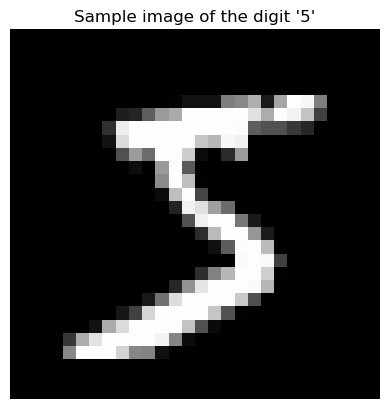

In [4]:
train_images = train_images / 255
test_images = test_images / 255

plt.figure()
plt.imshow(np.reshape(train_images[0], (28, 28)), cmap="gray")
plt.axis("off")
plt.title(f"Sample image of the digit '{train_labels[0]}'")
plt.show()

Next, we have to convert the data from the MNIST format into the sequence of pixels that
is used in the psMNIST task. To do this, we flatten the image by calling the `reshape`
method on the images. The first dimension of the reshaped output size represents the
number of samples our dataset has, which we keep the same. We want to transform each
sample into a column vector, and to do so we make the second and third dimensions -1 and
1, respectively.

The image displayed below shows the result of this flattening process, and is an example
of the type of data that is used in the Sequential MNIST task. Note that even though the
image has been flattened, there is still a fair amount of structure observable in the
image.

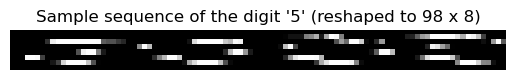

In [5]:
train_images = train_images.reshape((train_images.shape[0], -1, 1))
test_images = test_images.reshape((test_images.shape[0], -1, 1))

# we'll display the sequence in 8 rows just so that it fits better on the screen
plt.figure()
plt.imshow(train_images[0].reshape(8, -1), cmap="gray")
plt.axis("off")
plt.title(f"Sample sequence of the digit '{train_labels[0]}' (reshaped to 98 x 8)")
plt.show()

Finally, we apply a fixed permutation on the images in both the training and testing
datasets. This shuffles the pixels of the image sequences in a consistent
way, allowing for images of the same digit to still be similar, but removing the
convenience of edges and contours that the network can use for easy digit inference.

We can see, from the image below, that the fixed permutation applied to the image
creates an even distribute of pixels across the entire sequence. This makes the task
much more difficult, as it makes it necessary for the network to process the entire
input
sequence to accurately classify the digit. We now have our data for the Permuted
Sequential MNIST (psMNIST) task.

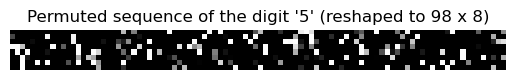

In [6]:
perm = rng.permutation(train_images.shape[1])
train_images = train_images[:, perm]
test_images = test_images[:, perm]

plt.figure()
plt.imshow(train_images[0].reshape(8, -1), cmap="gray")
plt.axis("off")
plt.title(f"Permuted sequence of the digit '{train_labels[0]}' (reshaped to 98 x 8)")
plt.show()

From the images in the training set, we allocate the first 50,000 images for training,
and the remaining 10,000 for validation. We print out the shapes of these datasets to
ensure the slicing has been done correctly.

In [7]:
X_train = train_images[:50000]
X_valid = train_images[50000:]
X_test = test_images

Y_train = train_labels[:50000]
Y_valid = train_labels[50000:]
Y_test = test_labels

print(
    f"Training inputs shape: {X_train.shape}, "
    f"Training targets shape: {Y_train.shape}"
)
print(
    f"Validation inputs shape: {X_valid.shape}, "
    f"Validation targets shape: {Y_valid.shape}"
)
print(f"Testing inputs shape: {X_test.shape}, Testing targets shape: {Y_test.shape}")

Training inputs shape: (50000, 784, 1), Training targets shape: (50000,)
Validation inputs shape: (10000, 784, 1), Validation targets shape: (10000,)
Testing inputs shape: (10000, 784, 1), Testing targets shape: (10000,)


## Defining the model

Our model uses a single LMU layer configured with 212 hidden `units` and an `order` of
256
dimensions for the memory, maintaining `units` + `order` = 468 variables in memory
between time-steps. These numbers were chosen primarily to have a comparable number of
internal variables to the models that were being compared against in the
[paper](https://arxiv.org/pdf/1504.00941.pdf).
We set `theta` to 784 (the number of pixels in each sequence). We also disable the
`hidden_to_memory` and `memory_to_memory` connections, as based on our experimentation
they are not needed/helpful in this problem.

The output of the LMU layer is connected to a `Dense` linear layer with an output
dimensionality of 10, one for each possible digit class.

In [8]:
n_pixels = X_train.shape[1]

lmu_layer = keras_lmu.LMU(
    memory_d=1,
    order=256,
    theta=n_pixels,
    hidden_cell=keras.layers.SimpleRNNCell(212),
    hidden_to_memory=False,
    memory_to_memory=False,
    input_to_hidden=True,
    kernel_initializer="ones",
)

# TensorFlow layer definition
inputs = keras.Input((n_pixels, 1))
lmus = lmu_layer(inputs)
outputs = keras.layers.Dense(10)(lmus)

# TensorFlow model definition
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="adam",
    metrics=["accuracy"],
)
model.summary()

2025-06-03 21:40:27.928372: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 784, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lmu (LMU)                       │ (None, 212)            │        99,641 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         2,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,771 (397.54 KB)

 Trainable params: 101,771 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

## Training the model

To train our model we use a `batch_size` of 100 and train for 10 `epochs`, which is
far less than most other solutions to the psMNIST task. We could train for more epochs
if we wished to fine-tune performance, but that is not necessary for the purposes of
this example. We also create a `ModelCheckpoint` callback that saves the weights of the
model to a file after each epoch.

Training may take
a long time to complete, and to save time this notebook defaults to using pre-trained
weights. To train the model from scratch, simply change the `do_training` variable to
`True` before running the cell below.

In [9]:
do_training = False
batch_size = 100
epochs = 10

saved_model_fname = "./psMNIST.keras"
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=saved_model_fname,
        monitor="val_accuracy",
        verbose=1,
        save_best_only=True,
    ),
]

result = None
if do_training:
    result = model.fit(
        X_train,
        Y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_valid, Y_valid),
        callbacks=callbacks,
    )

The progression of the training process is shown below, plotting the
training and validation accuracy.

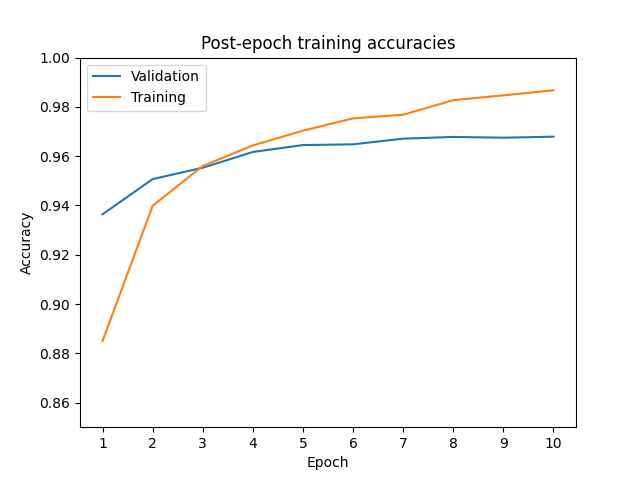

In [10]:
if do_training:
    plt.figure()
    plt.plot(result.history["val_accuracy"], label="Validation")
    plt.plot(result.history["accuracy"], label="Training")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Post-epoch training accuracies")
    plt.xticks(np.arange(epochs), np.arange(1, epochs + 1))
    plt.ylim((0.85, 1.0))  # Restrict range of y axis to (0.85, 1) for readability
    plt.savefig("psMNIST-training.png")

    val_loss_min = np.argmin(result.history["val_loss"])
    print(
        f"Maximum validation accuracy: "
        f"{round(result.history['val_accuracy'][val_loss_min] * 100, 2):.2f}%"
    )

else:
    display(Image(filename="psMNIST-training.png"))

## Testing the model

With the training complete, let's use the trained weights to test the model. Since the
best weights are saved to file, we can simply load the saved weights, then
test it against the permuted sequences in the test set.

In [11]:
model.load_weights(saved_model_fname)
accuracy = model.evaluate(X_test, Y_test, verbose=0)[1] * 100
print(f"Test accuracy: {round(accuracy, 2):0.2f}%")

/home/runner/micromamba/envs/ci/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Test accuracy: 96.41%


As the results demonstrate, the LMU network has achieved greater than 96% accuracy on
the test dataset. This is considered state-of-the-art for the psMNIST task, which is
made more impressive considering the model has only been trained for 10 epochs.